# Actor-Critic Methods
Loosely based on https://gymnasium.farama.org/tutorials/gymnasium_basics/vector_envs_tutorial/#sphx-glr-tutorials-gymnasium-basics-vector-envs-tutorial-py

## Packages, Imports, Helpers, and Initialization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

!pip install gymnasium

import gymnasium as gym

print(f"Gym version: {gym.__version__}")
print(f"Torch version: {torch.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 3.7 MB/s eta 0:00:00
Gym version: 0.29.1
Torch version: 2.1.0+cu121


### Helpers

In [ ]:
# Video management imports
import cv2

# Helper functions to save videos and images
def save_video(img_array, path='./video/test.mp4'):
  height, width, layers = img_array[0].shape
  size = (width, height)
  out = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'mp4v'), 15, size)
  for i in range(len(img_array)):
    bgr_img = cv2.cvtColor(img_array[i], cv2.COLOR_RGB2BGR)
    out.write(bgr_img)
  out.release()
  print('Video saved.')

def save_images(img_array, path='./images'):
  for i, image in enumerate(img_array):
    bgr_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path + '/img_' + str(i) + '.jpg', bgr_img)

## Loss Function

The loss function for the actor is

$$ \mathcal{L}(\theta_{t}) = \mathbb{E}_{\pi}[A_{\pi}(S_t, A_t) \log \pi(A_t | S_t, \theta_t)] $$

where $A_{\pi}(S_t, A_t)$ is the advantage, that is computed as $A_{\pi}(S_t, A_t) = Q_{\pi}(S_t, A_t) - V_{\pi}(S_t)$. As we are taking the state and action from experience, $Q_{\pi}(S_t, A_t) = \mathbb{E}_{\pi}[G_t|S_t = s, A_t = a]$, so the advantage is

$$A_{\pi}(S_t, A_t) = G_t - V_{\pi}(S_t)$$

$\pi(A_t | S_t, \theta_t)$ is the policy we get from the DNN, i.e., the probability distribution over actions.

And the update is done in gradient *ascent* style

$$ \theta_{t+1} = \theta_t + \alpha \triangledown \mathcal{L}(\theta_{t})$$

The loss gradient is used to update the parameters, $\theta$, during the backward propagation of the DNN, so we don't do this step manually.

Note: As SGD and Adam optimizers follow a gradient *descent* method, we add a minus sign to the loss function.

The loss function for the critic is $$ \mathcal{L}(\mathbf{\text{w}}_t) = \mathbb{E}_{\pi}\left[ \left( V_{\pi}(S_t) - \hat{V}(S_t, \mathbf{\text{w}}_t) \right)^2 \right] $$

And the update is

$$ \mathbf{\text{w}}_{t+1} = \mathbf{\text{w}}_t + \alpha \triangledown \mathcal{L}(\mathbf{\text{w}}_t)$$

Which may be a MSE or similar.

The loss of the actor-critic is

$$\mathcal{L}(\theta_{t}) + \mathcal{L}(\mathbf{\text{w}}_t)$$

## Actor-Critic A2C Agent

In [ ]:
class A2CAgent(nn.Module):
    """
    (Synchronous) Advantage Actor-Critic agent class

    Args:
        n_features: The number of features of the input state.
        n_actions: The number of actions the agent can take.
        device: The device to run the computations on (running on a GPU might be quicker for larger Neural Nets,
                for this code CPU is totally fine).
        critic_lr: The learning rate for the critic network (should usually be larger than the actor_lr).
        actor_lr: The learning rate for the actor network.
        n_envs: The number of environments that run in parallel (on multiple CPUs) to collect experiences.
    """

    def __init__(
        self,
        n_features: int,
        n_actions: int,
        critic_lr: float,
        actor_lr: float,
        device: torch.device
    ) -> None:
        """Initializes the actor and critic networks and their respective optimizers."""
        super().__init__()
        self.device = device

        critic_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),  # estimate V(s)
        ]

        actor_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(
                32, n_actions
            ),  # estimate action logits (will be fed into a softmax later)
        ]

        # define actor and critic networks
        self.critic = nn.Sequential(*critic_layers).to(self.device)
        self.actor = nn.Sequential(*actor_layers).to(self.device)

        # define optimizers for actor and critic
        self.critic_optim = optim.RMSprop(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.RMSprop(self.actor.parameters(), lr=actor_lr)

    def forward(self, x: np.ndarray) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the networks.

        Args:
            x: A batched vector of states.

        Returns:
            state_values: A tensor with the state values, with shape [n_envs,].
            action_logits_vec: A tensor with the action logits, with shape [n_envs, n_actions].
        """
        x = torch.Tensor(x).to(self.device)
        state_values = self.critic(x)  # shape: [n_envs,]
        action_logits_vec = self.actor(x)  # shape: [n_envs, n_actions]
        return (state_values, action_logits_vec)

    def select_action(
        self, x: np.ndarray
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns a tuple of the chosen actions and the log-probs of those actions.

        Args:
            x: A batched vector of states.

        Returns:
            actions: A tensor with the actions, with shape [n_steps_per_update, 1].
            action_log_probs: A tensor with the log-probs of the actions, with shape [STEPS_PER_UPDATE, 1].
            state_values: A tensor with the state values, with shape [STEPS_PER_UPDATE, 1].
        """
        state_values, action_logits = self.forward(x)
        action_pd = torch.distributions.Categorical(logits=action_logits)  # implicitly uses softmax
        actions = action_pd.sample()
        action_log_probs = action_pd.log_prob(actions)
        entropy = action_pd.entropy()
        return (actions, action_log_probs, state_values, entropy)

    def get_losses(
        self,
        rewards: torch.Tensor,
        action_log_probs: torch.Tensor,
        value_preds: torch.Tensor,
        entropy: torch.Tensor,
        masks: torch.Tensor,
        gamma: float,
        lam: float,
        ent_coef: float,
        device: torch.device,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Computes the loss of a minibatch (transitions collected in one sampling phase) for actor and critic
        using Generalized Advantage Estimation (GAE) to compute the advantages (https://arxiv.org/abs/1506.02438).

        Args:
            rewards: A tensor with the rewards for each time step in the episode, with shape [STEPS_PER_UPDATE, n_envs].
            action_log_probs: A tensor with the log-probs of the actions taken at each time step in the episode, with shape [STEPS_PER_UPDATE, n_envs].
            value_preds: A tensor with the state value predictions for each time step in the episode, with shape [STEPS_PER_UPDATE, n_envs].
            masks: A tensor with the masks for each time step in the episode, with shape [STEPS_PER_UPDATE, n_envs].
            gamma: The discount factor.
            lam: The GAE hyperparameter. (lam=1 corresponds to Monte-Carlo sampling with high variance and no bias,
                                          and lam=0 corresponds to normal TD-Learning that has a low variance but is biased
                                          because the estimates are generated by a Neural Net).
            device: The device to run the computations on (e.g. CPU or GPU).

        Returns:
            critic_loss: The critic loss for the minibatch.
            actor_loss: The actor loss for the minibatch.
        """
        T = len(rewards)
        advantages = torch.zeros(T, 1, device=device)

        # compute the advantages using GAE
        gae = 0.0
        for t in reversed(range(T - 1)):
            td_error = ( rewards[t] + gamma * masks[t] * value_preds[t + 1] - value_preds[t] )
            gae = td_error + gamma * lam * masks[t] * gae
            advantages[t] = gae

        # calculate the loss of the minibatch for actor and critic
        critic_loss = advantages.pow(2).mean()

        # give a bonus for higher entropy to encourage exploration
        actor_loss = (-(advantages.detach() * action_log_probs).mean() - ent_coef * entropy.mean())
        return (critic_loss, actor_loss)

    def update_parameters(self, critic_loss: torch.Tensor, actor_loss: torch.Tensor) -> None:
        """
        Updates the parameters of the actor and critic networks.

        Args:
            critic_loss: The critic loss.
            actor_loss: The actor loss.
        """
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

## Training

In [ ]:
# Let's define some training parameters
EPISODES = 600
STEPS_PER_UPDATE = 128
CRITIC_LR = 0.01
ACTOR_LR = 0.01
GAMMA = 0.999
LAM = 0.95
ENT_COEF = 0.01
ENV_NAME = 'CartPole-v1'

In [ ]:
# Initialize training device, gym envirobment and agent
device = torch.device("cpu")
env = gym.make(ENV_NAME, render_mode='rgb_array')
agent = A2CAgent(n_features=4, n_actions=env.action_space.n, critic_lr=0.001, actor_lr=0.005, device=device)

In [ ]:
# Training!
critic_losses = []
actor_losses = []
entropies = []
episode_returns = []

# use tqdm to get a progress bar for training
for episode in range(EPISODES):
    # we don't have to reset the envs, they just continue playing
    # until the episode is over and then reset automatically

    # reset lists that collect experiences of an episode (sample phase)
    ep_value_preds = torch.zeros(STEPS_PER_UPDATE, 1, device=device)
    ep_rewards = torch.zeros(STEPS_PER_UPDATE, 1, device=device)
    ep_action_log_probs = torch.zeros(STEPS_PER_UPDATE, 1, device=device)
    masks = torch.zeros(STEPS_PER_UPDATE, 1, device=device)
    states, _ = env.reset()

    # reset the accumulated reward
    episode_reward = 0
    # play n steps in our parallel environments to collect data
    for step in range(STEPS_PER_UPDATE):
        # select an action A_{t} using S_{t} as input for the agent
        actions, action_log_probs, state_value_preds, entropy = agent.select_action(states)

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        states, rewards, terminated, truncated, infos = env.step(actions.cpu().numpy())
        done = terminated or truncated

        episode_reward +=rewards

        ep_value_preds[step] = torch.squeeze(state_value_preds)
        ep_rewards[step] = torch.tensor(rewards, device=device)
        ep_action_log_probs[step] = action_log_probs

        # add a mask (for the return calculation later);
        # for each env the mask is 1 if the episode is ongoing and 0 if it is done (not by truncation!)
        masks[step] = torch.tensor([not done])

    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(
        ep_rewards,
        ep_action_log_probs,
        ep_value_preds,
        entropy,
        masks,
        GAMMA,
        LAM,
        ENT_COEF,
        device,
    )

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())
    episode_returns.append(episode_reward)

## Testing the AC Agent

In [ ]:
observation, _ = env.reset()
img_array = []
cumulative_reward = 0
step = 0
done = False
while not done:
  with torch.no_grad():
    action, _, _, _ = agent.select_action(observation[None, :])
    observation, reward, done, truncated, info = env.step(action.item())
    done = done or truncated
    image = env.render()
    img_array.append(image)

save_video(img_array, './video/A2C_cart_pole.mp4')

Video saved.


In [ ]:
from IPython.display import Video
Video('./video/A2C_cart_pole.mp4', embed=True)

## Viewing Statistics

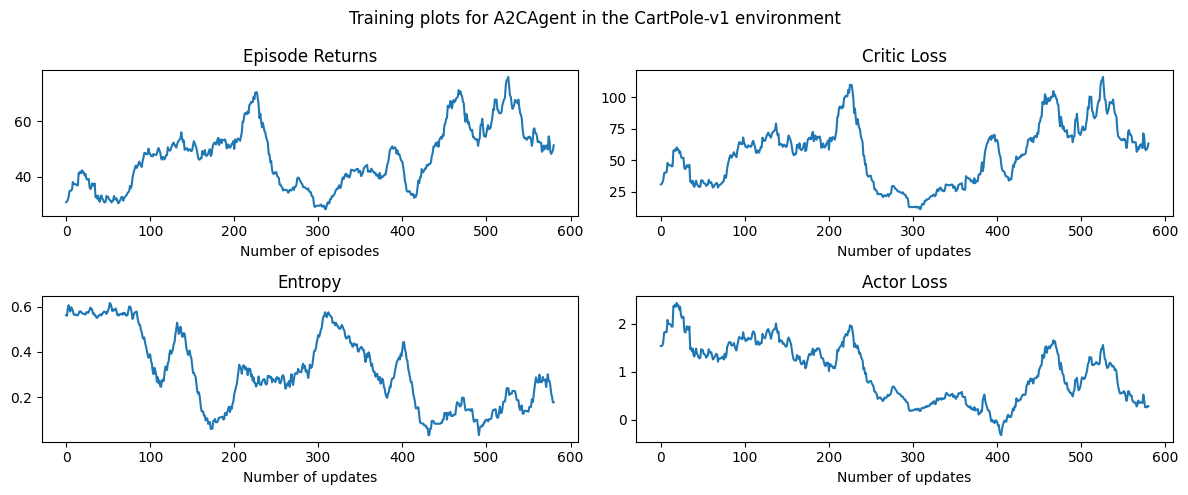

In [ ]:
""" plot the results """

# %matplotlib inline

rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f"Training plots for {agent.__class__.__name__} in the {ENV_NAME} environment")

# episode return
axs[0][0].set_title("Episode Returns")

episode_returns_moving_average = (
    np.convolve(
        np.array(episode_returns).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)),
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

## I have framed the problem as follows: I have made several combinations of the learning rates, which I will refer to as AR (Actor learning rate) and CR (Critic learning rate).

### Combinaciones: CR =  y AR =
### 1. CR = 0.005 y AR = 0.001 (base)
### 2. CR = 0.005 y AR = 0.005
### 3. CR = 0.001 y AR = 0.001
### 4. CR = 0.001 y AR = 0.005
### 5. CR = 0.01 y AR = 0.01

## The combinations of the Critic learning rate (CR) and the Actor learning rate (AR) can have a significant impact on the training process and, consequently, on the rewards obtained by the agent.

 ## 1. EPISODES = 600 STEPS_PER_UPDATE = 128 CRITIC_LR = 0.005 ACTOR_LR = 0.001 GAMMA = 0.999 LAM = 0.95

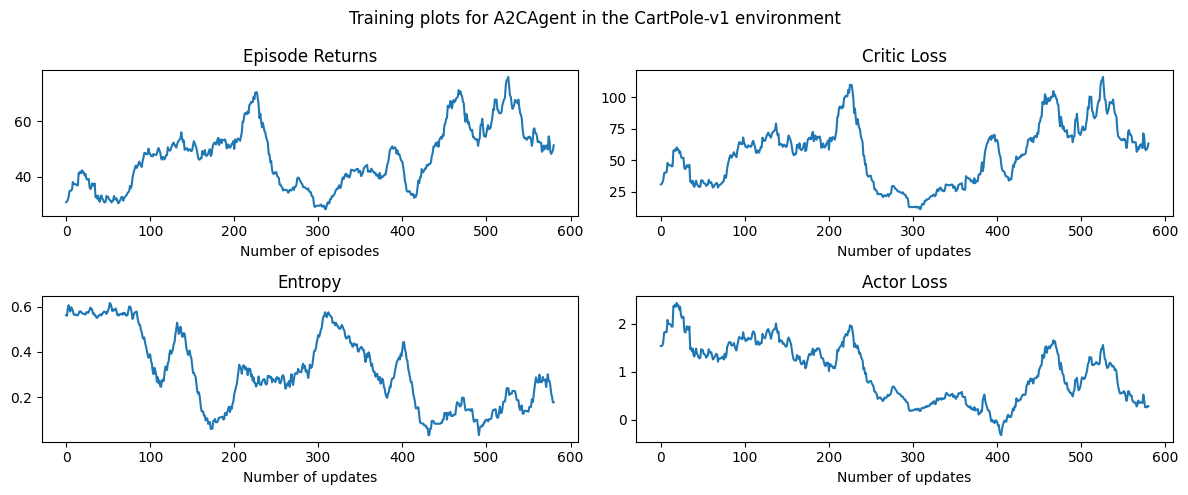

In [ ]:
""" plot the results """

# %matplotlib inline

rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f"Training plots for {agent.__class__.__name__} in the {ENV_NAME} environment")

# episode return
axs[0][0].set_title("Episode Returns")

episode_returns_moving_average = (
    np.convolve(
        np.array(episode_returns).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)),
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

## A moderate critic learning rate ensures stable value estimates, and the low actor learning rate leads to cautious policy updates. The agent learns steadily, and rewards gradually increase as the policy improves cautiously. This is the most stable combination.

 ## 2. EPISODES = 600 STEPS_PER_UPDATE = 128 CRITIC_LR = 0.005 ACTOR_LR = 0.005 GAMMA = 0.999 LAM = 0.95

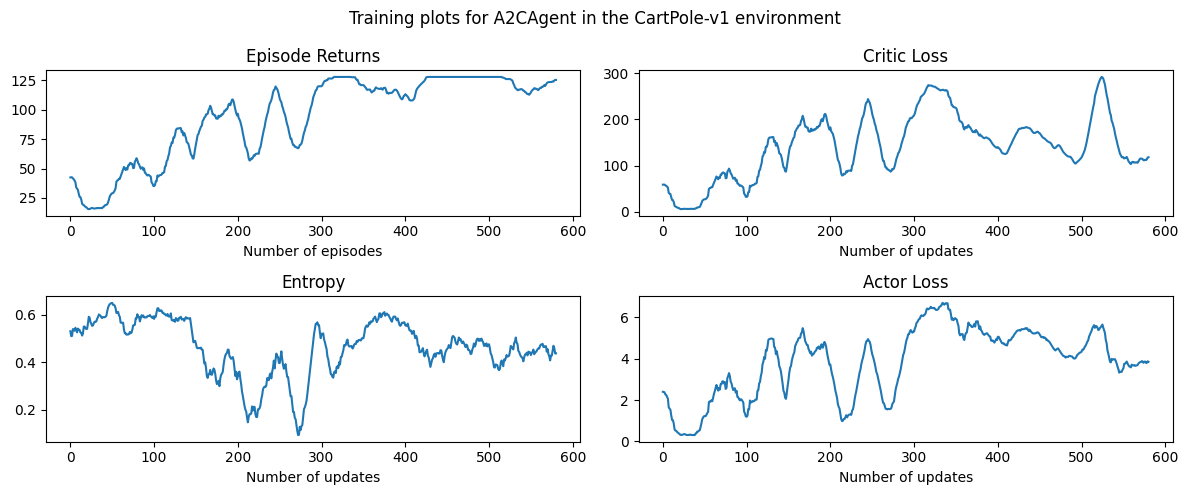

In [ ]:
""" plot the results """

# %matplotlib inline

rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f"Training plots for {agent.__class__.__name__} in the {ENV_NAME} environment")

# episode return
axs[0][0].set_title("Episode Returns")

episode_returns_moving_average = (
    np.convolve(
        np.array(episode_returns).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)),
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

## Both the critic and the actor are being updated at a moderate rate. The agent can adapt more quickly, and the rewards increase faster compared to the baseline case. However, there is some instability since the updates happen more rapidly. This can be observed both in the peaks of the graphs and in the increase of the critic and actor loss.

 ## 3. EPISODES = 600 STEPS_PER_UPDATE = 128 CRITIC_LR = 0.001 ACTOR_LR = 0.001 GAMMA = 0.999 LAM = 0.95

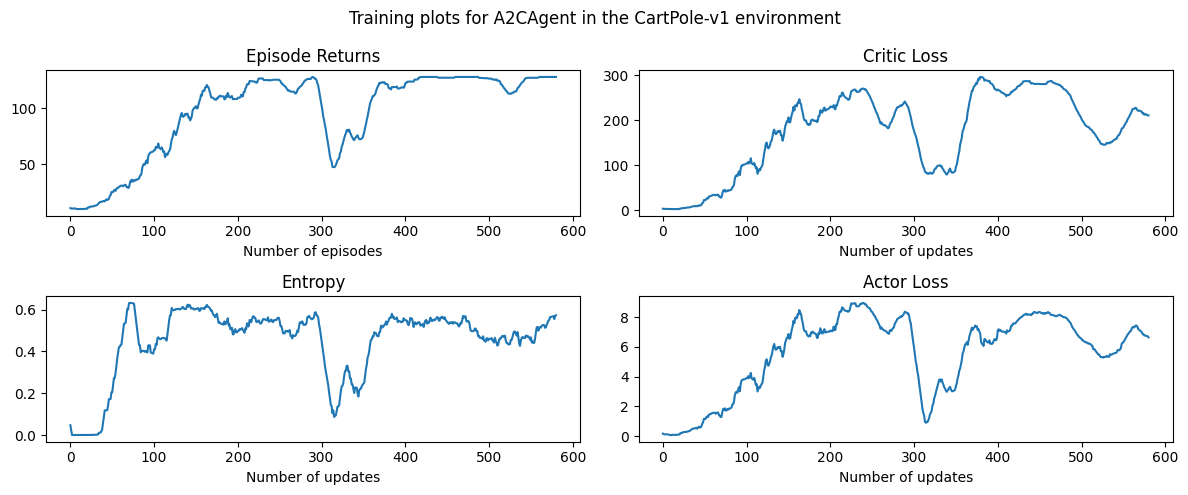

In [ ]:
""" plot the results """

# %matplotlib inline

rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f"Training plots for {agent.__class__.__name__} in the {ENV_NAME} environment")

# episode return
axs[0][0].set_title("Episode Returns")

episode_returns_moving_average = (
    np.convolve(
        np.array(episode_returns).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)),
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

## Both the critic and the actor are being updated slowly. The learning process is cautious, and rewards may take longer to increase. There is a risk of slower convergence, and the agent could get stuck in local minima.

 ## 4. EPISODES = 600 STEPS_PER_UPDATE = 128 CRITIC_LR = 0.001 ACTOR_LR = 0.005 GAMMA = 0.999 LAM = 0.95

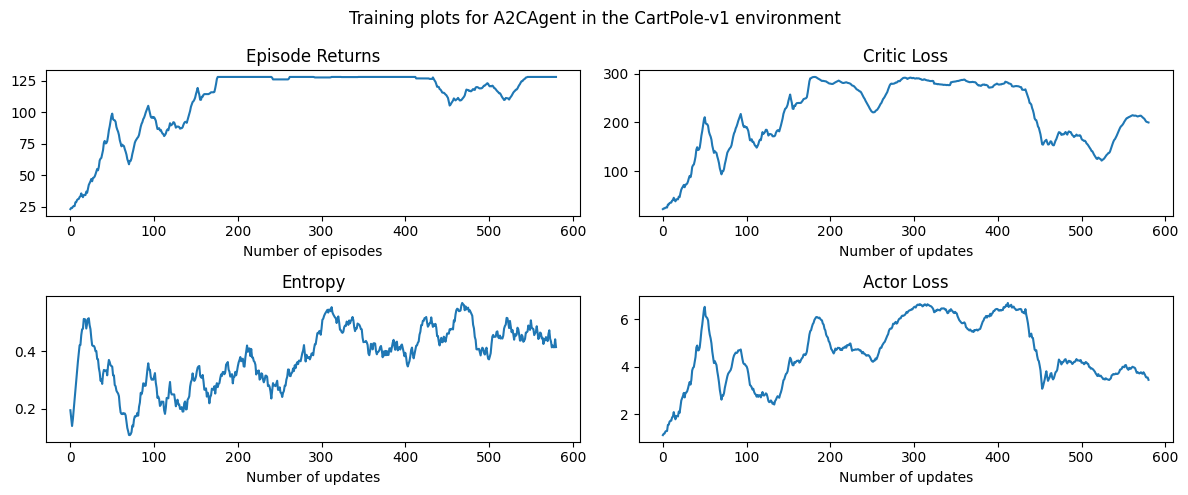

In [ ]:
""" plot the results """

# %matplotlib inline

rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f"Training plots for {agent.__class__.__name__} in the {ENV_NAME} environment")

# episode return
axs[0][0].set_title("Episode Returns")

episode_returns_moving_average = (
    np.convolve(
        np.array(episode_returns).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)),
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

## A low critic learning rate provides stable value estimates, and the moderate actor learning rate allows for relatively faster policy updates. The agent can find a balance between stability and adaptability, which leads to stable rewards.

 ## 5. EPISODES = 600 STEPS_PER_UPDATE = 128 CRITIC_LR = 0.01 ACTOR_LR = 0.01 GAMMA = 0.999 LAM = 0.95

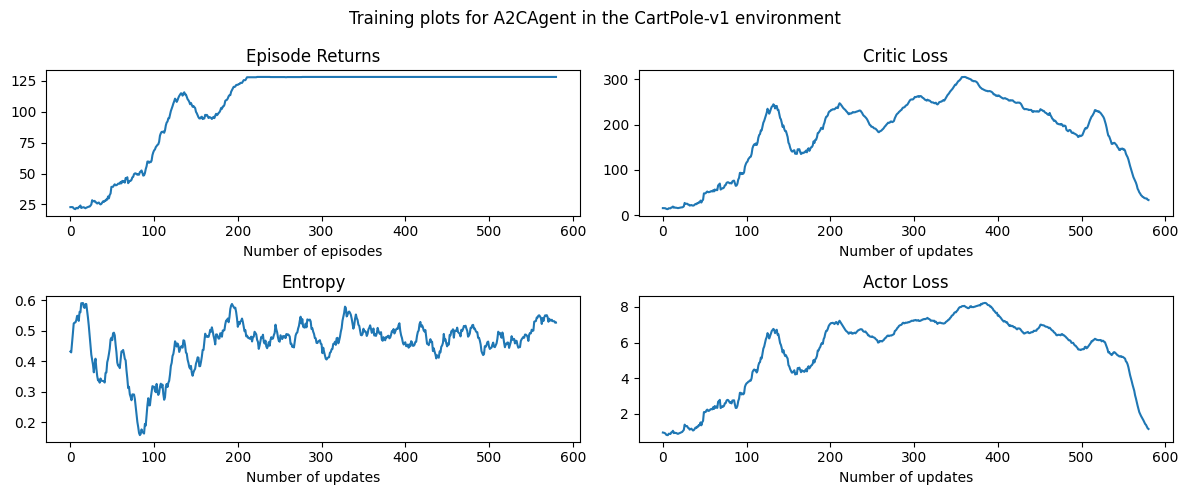

In [ ]:
""" plot the results """

# %matplotlib inline

rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f"Training plots for {agent.__class__.__name__} in the {ENV_NAME} environment")

# episode return
axs[0][0].set_title("Episode Returns")

episode_returns_moving_average = (
    np.convolve(
        np.array(episode_returns).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)),
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

## Both the critic and the actor are being updated at a high rate. The agent may experience rapid changes in both value estimates and policies. There is a higher risk of instability, and the rewards may show fluctuations or a more erratic progression. However, in this case—likely due to the type of environment we're working with—the rewards remain constant, as the agent has probably reached the optimal policy. This can be observed in the losses, which converge almost to zero.